## Monte Carlo simulation trial

In [2]:
%matplotlib inline
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
sys.path.append(os.path.abspath("../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("./Stacks/py"))
import qpq9_stacks as qpq9k
import scipy.integrate as integrate
from astropy.modeling import models,fitting
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70,Om0=0.26)

In [36]:
# the constants
n_trials = 1000
Deltav = 10.
v_grid = -2000. + np.arange((2000.-(-2000.))/Deltav+1)*Deltav
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
wave_grid = (v_grid*u.km/u.s).to(u.AA,equivalencies=relativistic_equiv)
Hubble_h = cosmo.H(0).value/100.

def gen_stck_img(R_phys,z_fg,stddev_oneabs,sigma1D,gen_shifted=False,half_open=60): 
    # R_phys in kpc, Deltav in km/s
    probs = np.zeros(len(v_grid))
    expected_num_abs = 0.
#    cumulative_probs = np.zeros(len(v_grid))
    ell_IGM_DLA = 0.2*((1+z_fg)/(1+2.5))**2.1
    ell_IGM_SLLS = 0.44*((1+z_fg)/(1+2.5))**2.1
    ell_IGM_LLS = 1.05*((1+z_fg)/(1+2.5))**2.1
    R_comov = R_phys/1000.*(1+z_fg)*Hubble_h # in h^-1 Mpc 
    # generate the probability grid in velcities
    for ii,vv in enumerate(v_grid):
        gamma_DLA = 1.6
        r0_DLA = 3.9
        gamma_SLLS = 1.68
        r0_SLLS = 14.0
        gamma_LLS = 1.68
        r0_LLS = 12.5
        chi_DLA = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg))*Hubble_h)**2)/r0_DLA)**(-gamma_DLA),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        chi_SLLS = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg))*Hubble_h)**2)/r0_SLLS)**(-gamma_SLLS),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        chi_LLS = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg))*Hubble_h)**2)/r0_LLS)**(-gamma_LLS),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        Deltaz = ltu.z_from_dv((v_grid[ii]+Deltav/2)*u.km/u.s,z_fg)-ltu.z_from_dv((v_grid[ii]-Deltav/2)*u.km/u.s,z_fg)
        prob = (ell_IGM_DLA*(1+chi_DLA)+ell_IGM_SLLS*(1+chi_SLLS)+ell_IGM_LLS*(1+chi_LLS))*Deltaz
        # test effect of doubling number of absorbers 
#        prob = prob*2
        probs[ii] = prob
        expected_num_abs += prob
#       cumulative_probs[ii] = prob + np.sum(probs[0:ii])
        if gen_shifted is True:
            # Assume a half-opening angle = half_open. 
            LOS_dist = v_grid[ii]/(cosmo.H(z_fg).value/(1+z_fg))*Hubble_h
#            if (-(0.3*(1+z_fg)*Hubble_h) < LOS_dist) and (LOS_dist < -(R_comov/np.tan(np.pi/180.*half_open))):
            if LOS_dist < -(R_comov/np.tan(np.pi/180.*half_open)):
                probs[ii] = 0.
#    print('Expected number of absorbers at R_phys',expected_num_abs,R_phys)   
    probs = probs/np.sum(probs)
    # expected rms Hubble velocity
#    v_Hubble_300kpc = 300./1000.*cosmo.H(z_fg).value
#    iend = np.argmin(np.abs(v_grid-v_Hubble_300kpc))
#    istart = np.argmin(np.abs(v_grid-(-v_Hubble_300kpc)))
#    print('Expected rms Hubble velocity within 300 kpc =',np.sqrt(np.sum((v_grid[istart:iend+1]**2)*probs[istart:iend+1])))
    # generate the stack image
    stck_img = np.zeros((n_trials,len(v_grid)))
    # generate the flux array for each monte carlo trial
    for nt in np.arange(n_trials):
        N_abs = np.random.poisson(expected_num_abs)
        flux = np.ones(len(v_grid))
        for ii,na in enumerate(np.arange(N_abs)):
            v_Hubble = np.random.choice(v_grid,p=probs)
            Hubble_dist = v_Hubble/(cosmo.H(z_fg).value/(1+z_fg))*Hubble_h
            if np.sqrt(Hubble_dist**2. + R_comov**2.) < 300./1000.*(1+z_fg)*Hubble_h:
#            if True:
                if (gen_shifted is True):  
                    v_peculiar = 500*np.sin(np.arctan(Hubble_dist/R_comov))
#                    v_peculiar = np.random.normal(loc=0.,scale=sigma1D)
                else:
                    v_peculiar = np.random.normal(loc=0.,scale=sigma1D)  
            else:
                v_peculiar = np.random.normal(loc=0.,scale=114.) 
#                v_peculiar = np.random.normal(loc=0.,scale=sigma1D)
            v_add = v_Hubble + v_peculiar
#            v_add = v_peculiar
            one_abs = models.GaussianAbsorption1D(amplitude=2.0,mean=v_add,stddev=stddev_oneabs)
            flux = flux*one_abs(v_grid)
            flux[np.where(flux < 0.)] = 0.
        stck_img[nt,:] = flux        
    return stck_img

In [4]:
def stddev_oneabs_to_WCII(stddev_oneabs):
    one_abs = models.GaussianAbsorption1D(amplitude=2.0,mean=0,stddev=stddev_oneabs)
    flux = one_abs(v_grid)
    flux[np.where(flux < 0.)] = 0.
    tau = -np.log(flux)
    total_flux = np.exp(-tau)
    #plt.plot(v_grid,total_flux,drawstyle='steps-mid',linewidth=2)
    W_CII = np.sum((1.-total_flux[:-1])*np.diff(wave_grid.value))
    return W_CII
    #plt.axis([-200,200,0,1.05])

In [5]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,
                               vsig_cut=400*u.km/u.s,zfg_mnx=(1.6,9999),plot_indiv=False)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ003423.40-104956.3_b1200_F.fits.gz for BOSSJ0034-1049
S/N in rest frame: 27.395062906 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-6267-56279-0926.fits.gz for SDSSJ0143+2954
S/N in rest frame: 6.33441423372 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
No spectrum found for SDSSJ0233

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")
/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)



Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ123141.73+002913.9_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N in rest frame: 78.1900954682 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
No continuum: spec-7416-56810-0860.fits.gz
No spectrum found for SDSSJ1253+4751 and wvobs=3783.95 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ130603.55+615835.2_b1200_F.fits.gz for APOJ1306+6158
S/N in rest frame: 32.2260362938 1 / Angstrom
Database is QPQ
Created on 2017-Ja

In [6]:
def model_width(stddev_oneabs,sigma1D,all_dict,gen_shifted=False,half_open=60):
    sv_mean_flux = []
    for ii,idict in enumerate(all_dict):
        if idict is None:
            continue
        if (('J0143+2954' in idict['qpq']['NAME']) or ('J0850+4755' in idict['qpq']['NAME']) or 
            ('J0951+4932' in idict['qpq']['NAME'])): # bad continua gave fake S/N 
            continue
        else:
            stck_img = gen_stck_img(idict['qpq']['R_PHYS'],idict['qpq']['Z_FG'],stddev_oneabs,sigma1D,
                                    gen_shifted=gen_shifted,half_open=half_open)
            mean_flux = np.sum(stck_img,0)/n_trials
            sv_mean_flux.append(mean_flux)
    mean_flux = np.mean(sv_mean_flux,0)
#    plt.figure(figsize=(8,5))
#    plt.plot(v_grid,mean_flux,drawstyle='steps-mid',linewidth=2.)
#    plt.axis([-2000,2000,0.65,1.05])
    model_init = models.GaussianAbsorption1D(amplitude=0.11,mean=0.,stddev=250.)
    c_init = models.Const1D(amplitude=0.997)
    model_init = c_init*model_init
    fit = fitting.LevMarLSQFitter()
    model_final = fit(model_init,v_grid,mean_flux)
#    plt.plot(v_grid,model_final(v_grid))
    return model_final.stddev_1.value,model_final.amplitude_1.value,model_final.mean_1.value

In [71]:
# make contour plot 
stddev_oneabs_grid = np.arange(10.,41.,10.)
sigma1D_grid = np.arange(60.,301.,40.)
#stddev_oneabs_grid = np.arange(10.,21.,2.5)
#sigma1D_grid = np.arange(85.,106.,5)
sigma1D_GRID,stddev_oneabs_GRID = np.meshgrid(sigma1D_grid,stddev_oneabs_grid)
widths = np.zeros_like(stddev_oneabs_GRID)
amps = np.zeros_like(stddev_oneabs_GRID)
for ii in np.arange(widths.shape[0]):
    print('ii=',ii,'of',widths.shape[0],'loops total')
    for jj in np.arange(widths.shape[1]):
        widths[ii,jj],amps[ii,jj],cen = model_width(stddev_oneabs_GRID[ii,jj],sigma1D_GRID[ii,jj],all_dict)

ii= 0 of 4 loops total
ii= 1 of 4 loops total
ii= 2 of 4 loops total
ii= 3 of 4 loops total


/Users/lwymarie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


array([[ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  1.01,  2.01,  3.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  3.01,  3.01,  1.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01,  1.01,  0.01]])

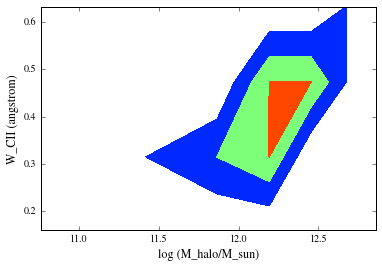

In [75]:
WCII_grid = np.zeros_like(stddev_oneabs_grid)
width_levels = [100,148,188,258,290,321]
amp_bounds = [0.089,0.141]
for ii,wcii in enumerate(WCII_grid):
    WCII_grid[ii] = stddev_oneabs_to_WCII(stddev_oneabs_grid[ii])
mass_grid = np.zeros_like(sigma1D_grid)
for ii,mass in enumerate(mass_grid):
    mass_grid[ii] = np.log10(2.37*10**26*(sigma1D_grid[ii]*1.4/1.07*1000)**3/(1.99*10**30))
mass_GRID,WCII_GRID = np.meshgrid(mass_grid,WCII_grid)
levels = np.zeros_like(stddev_oneabs_GRID)
for ii in np.arange(widths.shape[0]):
    for jj in np.arange(widths.shape[1]):
        if ((widths[ii,jj] >= width_levels[0]) & (widths[ii,jj] < width_levels[1])) | \
        ((widths[ii,jj] >= width_levels[4]) & (widths[ii,jj] < width_levels[5])):
            levels[ii,jj] = 1.
        if ((widths[ii,jj] >= width_levels[1]) & (widths[ii,jj] < width_levels[2])) | \
        ((widths[ii,jj] >= width_levels[3]) & (widths[ii,jj] < width_levels[4])):
            levels[ii,jj] = 2.
        if (widths[ii,jj] >= width_levels[2]) & (widths[ii,jj] < width_levels[3]):
            levels[ii,jj] = 3.
        if (amps[ii,jj] < amp_bounds[0]) | (amps[ii,jj] > amp_bounds[1]):
            levels[ii,jj] = 0.
levels = levels + 0.01  # truncation error
plt.contourf(mass_GRID,WCII_GRID,levels,levels=[1,2,3,4])
plt.xlabel('log (M_halo/M_sun)', size=12.)
plt.ylabel('W_CII (angstrom)', size=12.)
levels

In [87]:
hdu0 = fits.PrimaryHDU()
hdu1 = fits.ImageHDU(mass_GRID)
hdu2 = fits.ImageHDU(WCII_GRID)
hdu3 = fits.ImageHDU(levels)
hdulist = fits.HDUList([hdu0,hdu1,hdu2,hdu3])
hdulist.writeto('contour.fits',clobber=True)

In [8]:
# Find mean equivalent width of QPQ8 LLS
np.mean([0.000,0.042,0.345,0.195,0.025,0.030,0.053,0.168,0.504,0.248,0.779,0.281,0.341,
         0.328,0.756,0.650,0.154,0.179,0.130,0.950])

0.30790000000000001

        Use Gaussian1D and subtract it off Const1D instead. [astropy.utils.decorators]
        Use Gaussian1D and subtract it off Const1D instead.
        Use Gaussian1D and subtract it off Const1D instead. [astropy.utils.decorators]
        Use Gaussian1D and subtract it off Const1D instead.
        Use Gaussian1D and subtract it off Const1D instead. [astropy.utils.decorators]
        Use Gaussian1D and subtract it off Const1D instead.


(276.5423584091061, 0.12522892300564648, 0.79755475980605128)

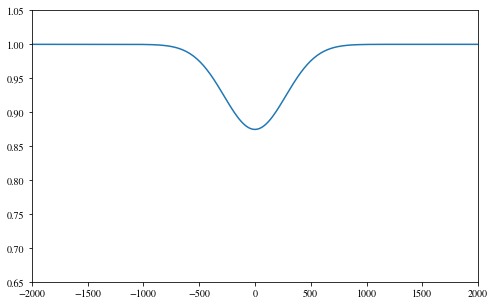

In [7]:
# 3 times modeling error smaller than observed width minus redshift error broadening gives intrinsic width 100 km/s
#width,amp,cen = model_width(13.,70.,all_dict,gen_shifted=False)
#width,amp,cen = model_width(25.5,191.,all_dict,gen_shifted=False)
width,amp,cen = model_width(34.,284.5,all_dict,gen_shifted=False)
plt.figure(figsize=(8,5))
plt.axis([-2000,2000,0.65,1.05])
model_final = models.GaussianAbsorption1D(amplitude=amp,mean=0.,stddev=width)
plt.plot(v_grid,model_final(v_grid))
width,amp,cen

        Use Gaussian1D and subtract it off Const1D instead. [astropy.utils.decorators]
        Use Gaussian1D and subtract it off Const1D instead.
        Use Gaussian1D and subtract it off Const1D instead. [astropy.utils.decorators]
        Use Gaussian1D and subtract it off Const1D instead.
        Use Gaussian1D and subtract it off Const1D instead. [astropy.utils.decorators]
        Use Gaussian1D and subtract it off Const1D instead.


(247.22902190901468, 0.1136331557043723, 1.1264434158812866)

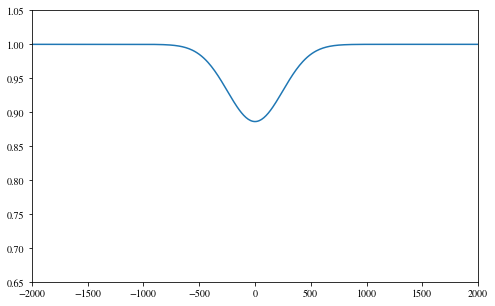

In [38]:
# QPQ halo mass sigma_1D
#width,amp,cen = model_width(31.5,246.,all_dict,gen_shifted=False)
width,amp,cen = model_width(27.5,246.,all_dict,gen_shifted=False)
#width,amp,cen = model_width(26.,246.,all_dict,gen_shifted=True,half_open=60)
plt.figure(figsize=(8,5))
plt.axis([-2000,2000,0.65,1.05])
model_final = models.GaussianAbsorption1D(amplitude=amp,mean=cen,stddev=width)
plt.plot(v_grid,model_final(v_grid))
width,amp,cen

In [15]:
# save model 
dict = {}
for ii,pp in enumerate(model_final.parameters):
    dict[model_final.param_names[ii]] = [pp]
ascii.write(Table(dict),'monte.dat')

In [61]:
stddev_oneabs_to_WCII(25.5)

/Users/lwymarie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


0.40672993971896476